In [1]:
import os
import glob
import numpy as np 
import xarray as xr
import pandas as pd
import datetime
from datetime import date, timedelta
import dask
import metpy as mp
from metpy.units import units
import metpy.calc as mpc
import Ngl

# Plotting utils 
import matplotlib
import matplotlib.pyplot as plt 
import cartopy
import cartopy.crs as ccrs


## Functions

In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

# - - - - - - - - - - - - - - - 
# Pre-process data while reading in 
# - - - - - - - - - - - - - - - 

def preprocess_atm(ds):
    ds         = cesm_correct_time(ds)
    dsSel      = ds[['SHFLX','LHFLX','PRECT']]
    # Also select spatial range
    dsSel = dsSel.sel(lat=slice(10,50), lon=slice(190,310))
    return dsSel

def preprocess_atm_profiles(ds):
    ds         = cesm_correct_time(ds)
    dsSel      = ds[['T','Q','PS','hyam','hyai','hybm','hybi','P0']]
    # Also select spatial range
    dsSel = dsSel.sel(lat=slice(10,50), lon=slice(190,310), lev=slice(500,1000))
    return dsSel

# # - - - - - - - - - - - - - - - 
# # Regrid utility 
# # - - - - - - - - - - - - - - - 
# def regrid_data(fromthis, tothis, method=1):
#     """Regrid data using various different methods"""

#     #Import necessary modules:
#     import xarray as xr

#     if method == 1:
#         # kludgy: spatial regridding only, seems like can't automatically deal with time
#         if 'time' in fromthis.coords:
#             result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
#             result = xr.concat(result, 'time')
#             return result
#         else:
#             return fromthis.interp_like(tothis)
#     elif method == 2:
#         newlat = tothis['lat']
#         newlon = tothis['lon']
#         coords = dict(fromthis.coords)
#         coords['lat'] = newlat
#         coords['lon'] = newlon
#         return fromthis.interp(coords)
#     elif method == 3:
#         newlat = tothis['lat']
#         newlon = tothis['lon']
#         ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
#         regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
#         return regridder(fromthis)
#     elif method==4:
#         # geocat
#         newlat = tothis['lat']
#         newlon = tothis['lon']
#         result = geocat.comp.linint2(fromthis, newlon, newlat, False)
#         result.name = fromthis.name
        
#         return result

#### Likely want a dask session too 

In [76]:
import dask
dask.config.set({'logging.distributed': 'error'})

from dask_jobqueue import PBSCluster

# For Casper
cluster = PBSCluster(
    queue="casper",
    walltime="04:00:00",
    account="P93300642",
    memory="10GB",
    resource_spec="select=1:ncpus=2:mem=10GB",
    cores=1,
    processes=1,
)

from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
print(client)

cluster.scale(32)

client.wait_for_workers(32)


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42571 instead
  warnings.warn(


<Client: 'tcp://128.117.208.100:40763' processes=0 threads=0, memory=0 B>


## Read in data 

In [3]:
caseNames = [
            'f.e21.F2000climo.f09_f09_mg17.S2S_LandAtmCoupling_output.002',
            'f.e21.F2000climo.f09_f09_mg17.ReduceDSL_0p8to0p5.S2S_LandAtmCoupling_output.002',
            # 'i.e21.I2000Clm50Sp.f09_f09_mg17.S2S_LandAtmCoupling_output.002',
            # 'f.e21.FHIST.f09_f09_mg17.S2S_LandAtmCoupling_output.002',
           ]

case_IDs = [
            'F2000climo_ctrl',
            'F2000climo_dsl0p5',
            # 'I2000Clm50Sp',
            # 'FHIST_ctrl', 
            ]

dataDir = '/glade/campaign/cgd/tss/people/mdfowler/LandAtmCoupling_longRuns/'


In [6]:
%%time 
for iCase in range(len(case_IDs)):
    print('*** Starting on case %s ***' % (case_IDs[iCase]))
 
    ## Select files with daily means (h1 files in this case)
    listFiles_atm     = np.sort(glob.glob(dataDir+caseNames[iCase]+'/atm/hist/*cam.h2.????-*'))
    listFiles_atm_lev = np.sort(glob.glob(dataDir+caseNames[iCase]+'/atm/hist/*cam.h3.????-*'))

    ## Now read in those files
    case_atm = xr.open_mfdataset(listFiles_atm,  preprocess=preprocess_atm, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal', parallel=True)
    print('atm files loaded')
    case_atm_lev = xr.open_mfdataset(listFiles_atm_lev,  preprocess=preprocess_atm_profiles, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal', parallel=True)
    print('atm 3D files loaded')

    
    ## Add case ID (short name) to the DS
    case_atm      = case_atm.squeeze().assign_coords({"case":  case_IDs[iCase]})
    case_atm_lev  = case_atm_lev.squeeze().assign_coords({"case":  case_IDs[iCase]})
    
    ## Return all the cases in a single dataset
    if iCase==0:
        atmDS    = case_atm
        del case_atm
        atmDS_3d = case_atm_lev
        del case_atm_lev
    else: 
        atmDS    = xr.concat([atmDS, case_atm], "case") 
        del case_atm
        atmDS_3d = xr.concat([atmDS_3d, case_atm_lev], "case") 
        del case_atm_lev
    

*** Starting on case F2000climo_ctrl ***
atm files loaded


KeyboardInterrupt: 

In [7]:
# Drop first year
iTimesKeep_atm   = np.where((atmDS['time.year'].values>=2) )[0]
atmDS            = atmDS.isel(time= iTimesKeep_atm)

iTimesKeep_atm3d   = np.where((atmDS_3d['time.year'].values>=2) )[0]
atmDS_3d            = atmDS_3d.isel(time= iTimesKeep_atm3d)


NameError: name 'atmDS' is not defined

In [ ]:
## Let's only use JJA too 
iTimesJJA = np.where((atmDS['time.month'].values>=6) & (atmDS['time.month'].values<=8))[0]
atmDS_JJA    = atmDS.isel(time=iTimesJJA)
atmDS_3d_JJA = atmDS_3d.isel(time=iTimesJJA)


## Compute TFS

In [8]:
## Select AM and PM times 
# Hour 16 UTC = 10a CST; 9a CDT
cdt = atmDS_JJA['time'] - timedelta(hours=5) 
cdt['time'] = cdt

# Select pre-sunrise time
#  5a CDT is 3a PDT/6a EDT
iAM = np.where(cdt['time.hour']==5)[0]
atmDS_preAM = atmDS_JJA.isel(time=iAM)
atmDS_3d_preAM = atmDS_3d_JJA.isel(time=iAM)

# 11a CDT is: 9a PDT and 12p EDT 
iAM = np.where(cdt['time.hour']==11)[0]
atmDS_am = atmDS_JJA.isel(time=iAM)

# 2p CDT is: 12p PDT/3p EDT ; 5p CDT is 3p PDT/6p EDT 
iPM = np.where( (cdt['time.hour']==14) | (cdt['time.hour']==17))[0]
atmDS_pm = atmDS_JJA.isel(time=iPM)


In [ ]:
np.unique(atmDS_JJA['time.hour'])

In [9]:
np.unique(cdt['time.hour'])

array([ 2,  5,  8, 11, 14, 17, 20, 23])

In [10]:
# Compute morning evaporative fraction 
EF_am = atmDS_am.LHFLX / (atmDS_am.LHFLX + atmDS_am.SHFLX)


In [11]:
def interpolateToPressure(DS, varName, pressGoals):
    p0mb = DS.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DS.hyam.values)[:]
    hybm = np.squeeze(DS.hybm.values)[:]
    hyai = np.squeeze(DS.hyai.values)[:]
    hybi = np.squeeze(DS.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    
    return varInterp


In [76]:
## Print original pressure levels
(1000*(atmDS_3d.hyam.values+atmDS_3d.hybm.values))

array([[524.68717471, 609.77869481, 691.38943031, 763.40448111,
        820.85836865, 859.53476653, 887.02024892, 912.64454694,
        936.19839847, 957.48547954, 976.32540739, 992.55609512],
       [524.68717471, 609.77869481, 691.38943031, 763.40448111,
        820.85836865, 859.53476653, 887.02024892, 912.64454694,
        936.19839847, 957.48547954, 976.32540739, 992.55609512]])

In [12]:
%%time
# Compute actual pressure levels 
P_interp = np.append(np.arange(550, 900, 50), np.arange(900,1000, 25))
P_interp = np.append(P_interp, 990)

# Each interp call takes ~2 min
T_interp_case0 = interpolateToPressure(atmDS_3d_preAM.isel(case=0), 'T', P_interp)
T_interp_case1 = interpolateToPressure(atmDS_3d_preAM.isel(case=1), 'T', P_interp)

Q_interp_case0 = interpolateToPressure(atmDS_3d_preAM.isel(case=0), 'Q', P_interp)
Q_interp_case1 = interpolateToPressure(atmDS_3d_preAM.isel(case=1), 'Q', P_interp)


CPU times: user 56.6 s, sys: 5.52 s, total: 1min 2s
Wall time: 8min 50s


In [13]:
T_interp = xr.DataArray([T_interp_case0, T_interp_case1], 
    coords={
            'case': atmDS_3d_preAM.case.values,
            'time': atmDS_3d_preAM.time.values,
            'lev': P_interp,
            'lat': atmDS_3d_preAM.lat.values, 
            'lon':atmDS_3d_preAM.lon.values}, 
    dims=["case","time","lev", "lat", "lon"])

Q_interp = xr.DataArray([Q_interp_case0, Q_interp_case1], 
    coords={
            'case': atmDS_3d_preAM.case.values,
            'time': atmDS_3d_preAM.time.values,
            'lev': P_interp,
            'lat': atmDS_3d_preAM.lat.values, 
            'lon':atmDS_3d_preAM.lon.values}, 
    dims=["case","time","lev", "lat", "lon"])


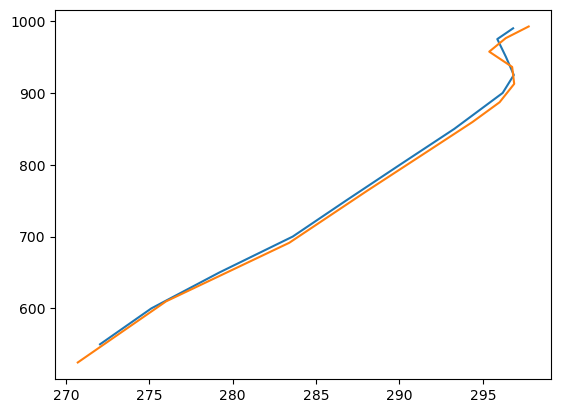

In [116]:
## Sanity check that interpolated profile looks okay: Temperature
plt.plot(T_interp.isel(case=0, time=10, lat=10, lon=50).values, T_interp.lev.values)
plt.plot(atmDS_3d_preAM.T.isel(case=0, time=10, lat=10, lon=50).values, atmDS_3d_preAM.lev.values)


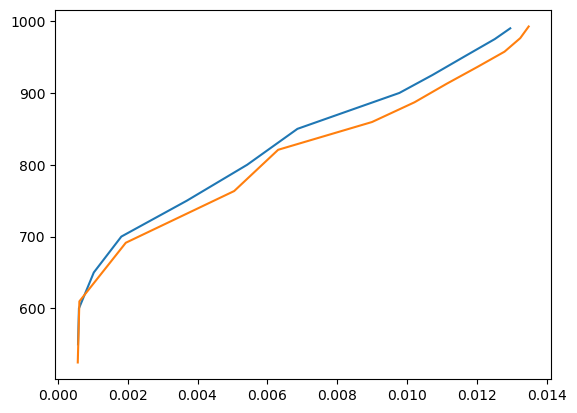

In [15]:
## Sanity check that interpolated profile looks okay: Moisture
plt.plot(Q_interp.isel(case=0, time=10, lat=20, lon=5).values, Q_interp.lev.values)
plt.plot(atmDS_3d_preAM.Q.isel(case=0, time=10, lat=20, lon=5).values, atmDS_3d_preAM.lev.values)


In [34]:
T_invertLev = T_interp.isel(lev=slice(None, None, -1))
Q_invertLev = Q_interp.isel(lev=slice(None, None, -1))


# Compute CTP (essentailly CAPE between two levels) 
dewpoint_case0 = mpc.dewpoint_from_specific_humidity(Q_invertLev.isel(lev=0).lev.values * units.hPa, Q_invertLev.isel(lev=0,case=0).values * units(atmDS_3d_preAM.Q.units))
dewpoint_case1 = mpc.dewpoint_from_specific_humidity(Q_invertLev.isel(lev=0).lev.values * units.hPa, Q_invertLev.isel(lev=0,case=1).values * units(atmDS_3d_preAM.Q.units))

# parcProfile_case1 = mpc.parcel_profile(Q_interp.isel(lev=-1).lev.values * units.hPa, 
#                                        T_interp.isel(case=1).values * units.K, 
#                                        dewpoint_case1) 


In [46]:
np.shape(dewpoint_case0)


(2300, 42, 97)

In [54]:
parcProfile_case0 = np.full([len(T_invertLev.time.values), len(T_invertLev.lev.values), len(T_invertLev.lat.values), len(T_invertLev.lat.values)], np.nan)

for iLat in range(len(T_invertLev.lat.values)): 
    for iLon in range(len(T_invertLev.lon.values)):
        for iT in range(len(T_invertLev.time.values)):

            parcProfile_case0[iT,:,iLat,iLon] = mpc.parcel_profile(Q_invertLev.lev.values * units.hPa, 
                                       T_invertLev.isel(case=0, lev=0, time=iT,lat=iLat,lon=iLon).values * units.K, 
                                       dewpoint_case0[iT,iLat,iLon]) 




IndexError: index 42 is out of bounds for axis 3 with size 42

In [43]:
parcProfile_case0

(2300, 42, 97)

## Try following METplus

https://github.com/dtcenter/METcalcpy/pull/394/commits/111876e6473954fb5042e421322bdbd2cb24e85b (code) 
https://github.com/dtcenter/METplus/issues/2390 


In [57]:
import metpy.constants as mpconsts
import numpy as np
from metpy import calc as mpcalc
from metpy.interpolate import log_interpolate_1d as log_interp_1d
from metpy.units import units
import os
from pandas.core.series import Series
from xarray.core.dataarray import DataArray

In [58]:
def calc_ctp(pressure,temperature,start_pressure_hpa=-1,bot_pressure_hpa=100.0,top_pressure_hpa=300.0,interp=False,db=False,plotskewt=False,plotdir="",station=""):

  """ Function for computing the Convective Triggering Potential
  Args:
      pressure (pint.Quantity): the vertical pressure profile
      temperature (pint.Quantity): the vertical temperature profile
      start_pressure_hpa (float, optional): the starting pressure to use. Default: -1 (bottom level in profile).
      bot_pressure_hpa (float, optional): bottom pressure value of the layer, added to start_pressure_hpa. Default: 100 hPa.
      top_pressure_hpa (float, optional): top pressure value of the layer, added to start_pressure_hpa. Default: 300 hPa.
      interp (bool): Whether to interpolate data to exact pressures or use the closest. Default: False.
      db (bool): Print debugging statements. Default: False
      plotskewt (bool): Plot a Skew-T Log-P graphic of the CTP calculation. Default: False.
      plotdir (string, optional): Directory where Skew-T plots should be written. Default: "".
      station (string, optional): Location ID string used for labeling the Skew-T plot and image file name. Default: "".
  Returns:
      float32
 
  Reference:
      TBD
  Notes:
      Lorem Ipsum
  """

  # Set a pressure difference for non-interpolation case
  # If the closest pressure to the bot_pressure_hpa is more
  # than this amount from the start_pressure_hpa, a warning will be
  # printed.
  max_prs_diff = 250.0*units('hPa')

  # Find the starting pressure in the profile
  if start_pressure_hpa < 0:
    start_prs = pressure[0]
    if db:
      print("")
      print("USING LOWEST STARTING PRESSURE: %f\n" % (start_prs.m))
  else:
    if interp:
      start_prs = log_interp_1d(start_pressure_hpa,pressure.m,pressure.m)
      start_prs = start_prs*units('hPa')
      # If the starting pressure is NaN, most likely the starting pressure was lower than
      # all the pressures in the sounding.
      if np.isnan(start_prs):
        if db:
          print("")
          print("WARNING. REQUESTED STARTING PRESSURE INVALID")
          print("UNABLE TO COMPUTE CTP.")
        return(-9999.*units('J/kg'))
      if db:
        print("")
        print("USING INTERPOLATED STARTING PRESSURE: %f\n" % (start_prs.m))
    else:
      # Find the closest value. We'll just take the difference between the start pressure and pressure
      # and find the index of the minimum
      prs_diff = pressure-(start_pressure_hpa*units('hPa'))
      start_prs = pressure[np.argmin(np.abs(prs_diff))]
      if np.abs(start_pressure_hpa-start_prs)>=max_prs_diff:
        print("")
        print("WARNING! ACTUAL STARTING PRESSURE IS AT LEAST %3.2f hPa FROM REQUESTED START PRESSURE." % (max_prs_diff.m))
        print("requested: start_pressure_hpa = %4.2f hPa" % (start_pressure_hpa.m))
        print("actual: start_pressure_hps = %4.2f hPa" % (start_prs.m))
      if db:
        print("")
        print("USING NEAREST STARTING PRESSURE: %f\n" % (start_prs.m))

  # Based on the starting pressure, set the initial layer bottom and top pressures
  layer_bot_prs = start_prs-(bot_pressure_hpa*units('hPa'))
  layer_top_prs = start_prs-(top_pressure_hpa*units('hPa'))

  if db:
    print("")
    print("TARGET LAYER BOTTOM PRESSURE: %f\n" % (layer_bot_prs.m))
    print("TARGET LAYER TOP PRESSURE: %f\n" % (layer_top_prs.m))

  # Obtain information at the top and bottom of the layer
  if interp:
    prsBot, tmpBot = log_interp_1d(layer_bot_prs.m,pressure.m,pressure.m,temperature.m)
    prsTop, tmpTop = log_interp_1d(layer_top_prs.m,pressure.m,pressure.m,temperature.m)
    if db:
      print("")
      print("USING INTERPOLATED LAYER BOTTOM PRESSURE: %f\n" % (prsBot))
      print("USING INTERPOLATED LAYER TOP PRESSURE: %f\n" % (prsTop))

    # Find the top and bottom of the layer, where the interpolated values should be inserted
    if any(np.where(np.diff(pressure.m)<=0)):
      if db:
        print("WARNING! PRESSURES DO NOT MONOTONICALLY DECREASE!")
        print("UNABLE TO COMPUTE CTP.")
      return(-9999.*units('J/kg'))
    layer_bot_idx = len(pressure.m)-np.searchsorted(pressure.m[::-1],prsBot,side="left")[0]
    layer_top_idx = len(pressure.m)-np.searchsorted(pressure.m[::-1],prsTop,side="left")[0]
    if db:
      print("")
      print("INSERTING INTERPOLATED BOT DATA AT INDEX: %02d" % (int(layer_bot_idx)))
      print("INSERTING INTERPOLATED TOP DATA AT INDEX: %02d" % (int(layer_top_idx)))

    # Create a new sounding to use, which has the interpolated T/P at bottom/top inserted
    prs = np.append(np.append(np.append(np.append(pressure.m[0:layer_bot_idx],prsBot),pressure.m[layer_bot_idx:layer_top_idx]),prsTop),pressure.m[layer_top_idx:])
    tmp = np.append(np.append(np.append(np.append(temperature.m[0:layer_bot_idx],tmpBot),temperature.m[layer_bot_idx:layer_top_idx]),tmpTop),temperature.m[layer_top_idx:])
    # Assign units to the new sounding variables
    prs = prs*units('hPa')
    tmp = tmp*units('degK')

    # Reset the variables as if this was the true sounding
    pressure = prs
    temperature = tmp

    # Find the new layer top and bottom indices, which should be the indices of the interpolated values that were inserted above
    layer_bot_idx = np.where(pressure.m==prsBot)[0][0]
    layer_top_idx = np.where(pressure.m==prsTop)[0][0]
    if db:
      print("")
      print("INDEX OF LAYER BOT: %02d" % (int(layer_bot_idx)))
      print("INDEX OF LAYER TOP: %02d" % (int(layer_top_idx)))

    # Compute the moist adiabatic lapse rate
    try:
      MALR = mpcalc.moist_lapse(pressure[layer_bot_idx:],tmpBot*units('degK'),reference_pressure=prsBot*units('hPa'))
    except ValueError:
      print("UNABLE TO COMPUTE MALR IN calc_ctp()")
      return(-9999.*units('J/kg'))

  else:

    # Find the index of the closest value. 
    # We'll just take the difference between the top/bottom pressure and find the index of the minimum
    bot_diff = pressure-layer_bot_prs
    top_diff = pressure-layer_top_prs
    layer_bot_idx = np.argmin(np.abs(bot_diff))
    layer_top_idx = np.argmin(np.abs(top_diff))
    if db:
      print("")
      print("INDEX OF LAYER BOT: %02d" % (int(layer_bot_idx)))
      print("INDEX OF LAYER TOP: %02d" % (int(layer_top_idx)))

    prsBot = pressure.m[layer_bot_idx]
    prsTop = pressure.m[layer_top_idx]
    tmpBot = temperature.m[layer_bot_idx]
    tmpTop = temperature.m[layer_top_idx]

    if db:
      print("")
      print("USING NEAREST LAYER BOTTOM PRESSURE: %f\n" % (prsBot))
      print("USING NEAREST LAYER TOP PRESSURE: %f\n" % (prsTop))

    # Compute the moist adiabatic lapse rate
    try:
      MALR = mpcalc.moist_lapse(pressure[layer_bot_idx:],tmpBot*units('degK'),reference_pressure=prsBot*units('hPa'))
    except ValueError:
      print("UNABLE TO COMPUTE MALR IN calc_ctp()")
      return(-9999.*units('J/kg'))

  # The MALR was only computed from the pressure at the bottom of the layer to the top of the sounding,
  # so subset the data to align with the levels where the MALR was computed
  ctp_prs = pressure[layer_bot_idx:]
  ctp_tmp = temperature[layer_bot_idx:]

  # Compute the difference between the environmental temperature profile and the MALR
  tdiff = (ctp_tmp-MALR)

  # Create a mask for the layer we want to integrate over
  p_mask = (ctp_prs<=pressure[layer_bot_idx])&(ctp_prs>=pressure[layer_top_idx])

  # Compute the Convective Triggering Potential (CTP) index
  CTP = mpconsts.Rd * units.Quantity(np.trapz(tdiff[p_mask].m,np.log(ctp_prs[p_mask].m)),'K')

  if plotskewt:
    import matplotlib.pyplot as plt
    from metpy.plots import SkewT
    fig = plt.figure(1, figsize=(22,15))
    skew = SkewT(fig=fig,rotation=45.0)
    skew.plot(pressure,temperature,'r',marker='.',linewidth=4)
    skew.ax.axhline(y=pressure[layer_bot_idx],xmin=-80,xmax=80,color='k',linewidth=2,linestyle='--')
    skew.ax.axhline(y=pressure[layer_top_idx],xmin=-80,xmax=80,color='k',linewidth=2,linestyle='--')
    skew.ax.fill_betweenx(pressure[layer_bot_idx:layer_top_idx+1],temperature[layer_bot_idx:layer_top_idx+1],MALR[0:(layer_top_idx-layer_bot_idx)+1])
    skew.plot(pressure[layer_bot_idx:],MALR,marker='.',linewidth=4,color='magenta')
    skew.ax.set_ylabel('Pressure (hPa)')
    skew.ax.set_xlabel('Temperature (C)')
    plt.title('CTP = %5.5f J/kg' % (float(CTP.m)),loc='left')
    plt.title('STATION = %s' % (station))
    fig.savefig(os.path.join(plotdir,'CTP_%s.png' % (station)))
    plt.close()

  return CTP


In [98]:
iT = 10 
iLat = 5
iLon = 10
iCase = 0 

print(
    calc_ctp(T_invertLev.lev.values * units.hPa,
                    T_invertLev.isel(case=iCase, time=iT,lat=iLat,lon=iLon).values * units.K,
                    start_pressure_hpa=-1,bot_pressure_hpa=100.0,top_pressure_hpa=300.0,
                    interp=False,db=False,plotskewt=False,plotdir="",station="").magnitude
     )


-141.15754677175775


In [70]:
parcProfile_case0 = np.full([len(T_invertLev.time.values), len(T_invertLev.lat.values), len(T_invertLev.lon.values)], np.nan)

for iLat in range(len(T_invertLev.lat.values)): 
    for iLon in range(len(T_invertLev.lon.values)):
        for iT in range(len(T_invertLev.time.values)):
            
            parcProfile_case0[iT, iLat, iLon] = calc_ctp(T_invertLev.lev.values * units.hPa,
                    T_invertLev.isel(case=0, time=iT,lat=iLat,lon=iLon).values * units.K,
                    start_pressure_hpa=-1,bot_pressure_hpa=100.0,top_pressure_hpa=300.0,
                    interp=False,db=False,plotskewt=False,plotdir="",station="").magnitude



KeyboardInterrupt: 

In [ ]:
parcProfile_case0_DS = xr.DataArray(parcProfile_case0, 
    coords={
            'time': atmDS_3d_preAM.time.values,
            'lat': atmDS_3d_preAM.lat.values, 
            'lon':atmDS_3d_preAM.lon.values}, 
    dims=["time", "lat", "lon"])


In [ ]:
parcProfile_case0_DS.isel(time=6).plot()